Import Tools and Libraries

In [3]:
pip install tensorflow

  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)
  Using cached h5py-3.15.1-cp311-cp311-win_amd64.whl (2.9 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import pickle

In [5]:
#NLP
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Embedding, LSTM, add, Input, Dense, Dropout, Concatenate, Reshape, concatenate, Bidirectional

In [6]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [7]:
plt.rcParams['font.size'] = 12
sns.set_style('dark')
warnings.filterwarnings('ignore')

Read Dataset

In [12]:
image_path = '../dataset/Images'
df = pd.read_csv('../dataset/captions.txt') 
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [13]:
image_read = os.listdir(image_path)
image_read

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg',
 '1007320043_627395c3d8.jpg',
 '1009434119_febe49276a.jpg',
 '1012212859_01547e3f17.jpg',
 '1015118661_980735411b.jpg',
 '1015584366_dfcec3c85a.jpg',
 '101654506_8eb26cfb60.jpg',
 '101669240_b2d3e7f17b.jpg',
 '1016887272_03199f49c4.jpg',
 '1019077836_6fc9b15408.jpg',
 '1019604187_d087bf9a5f.jpg',
 '1020651753_06077ec457.jpg',
 '1022454332_6af2c1449a.jpg',
 '1022454428_b6b660a67b.jpg',
 '1022975728_75515238d8.jpg',
 '102351840_323e3de834.jpg',
 '1024138940_f1fefbdce1.jpg',
 '102455176_5f8ead62d5.jpg',
 '1026685415_0431cbf574.jpg',
 '1028205764_7e8df9a2ea.jpg',
 '1030985833_b0902ea560.jpg',
 '103106960_e8a41d64f8.jpg',
 '103195344_5d2dc613a3.jpg',
 '103205630_682ca7285b.jpg',
 '1032122270_ea6f0beedb.jpg',
 '1032460886_4a598ed535.jpg',
 '1034276567_49bb87c51c.jpg',
 '104136873_5b5d41be75.jpg',
 '1042020065_fb3d3ba5ba.jpg',
 '1042590306_95dea

In [14]:
img_size = 224

def readImage(path, img_size):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255.
    return img

In [15]:
def display_image(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20,20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5,5, n)
        plt.subplots_adjust(hspace= 0.7, wspace=0.3)
        image = readImage(f"{image_path}/{temp_df.image[i]}", img_size)
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i], 20)))
        plt.axis('off')



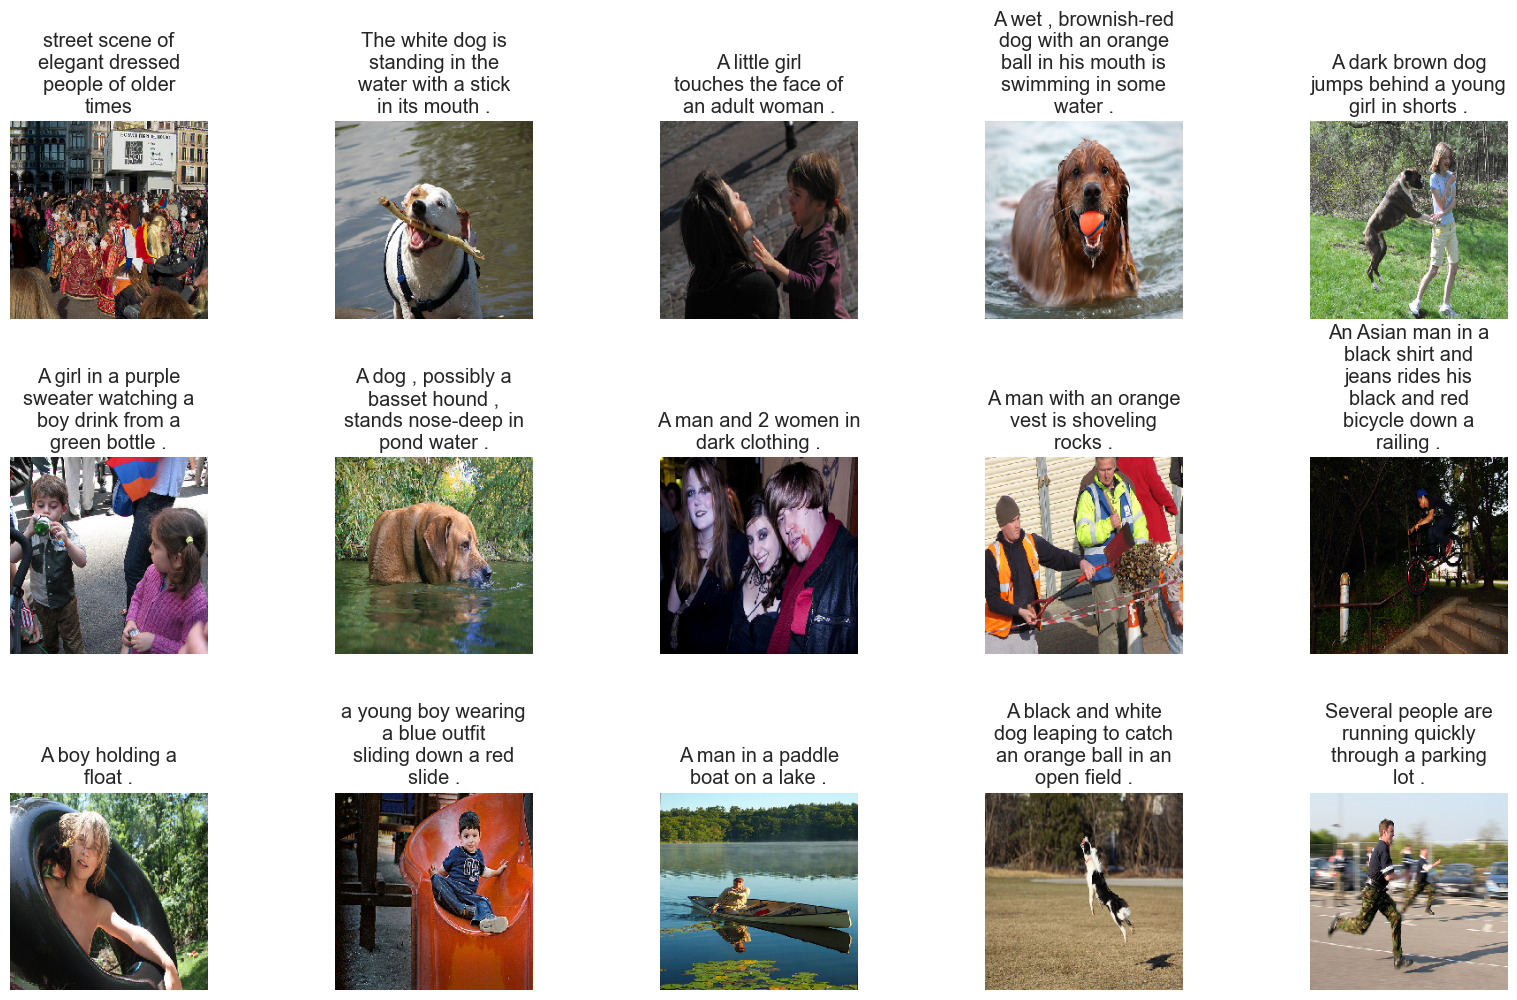

In [16]:
display_image(df.sample(15))

In [17]:
def text_preprocessing(df):
    df['caption'] = df['caption'].apply(lambda x: x.lower())
    df['caption'] = df['caption'].apply(lambda x: x.replace("[^A-Za-z]", ""))
    df['caption'] = df['caption'].apply(lambda x: x.replace("\s+", " "))
    df['caption'] = df['caption'].apply(
        lambda x: " ".join([word for word in x.split() if len(word) > 1])
    )
    
    df['caption'] = "startseq " + df['caption'] + " endseq"
    return df

df = text_preprocessing(df)
captions = df['caption'].tolist()
captions[:10]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [35]:
df.to_csv("processed_captions.csv", index=False)

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) +1

max_length = max([len(caption.split()) for caption in captions])

images = df['image'].unique ().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = df[df['image'].isin(train_images)]
test = df[df['image'].isin(val_images)]

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)


tokenizer.texts_to_sequences([captions[1]])[0]
nimages

8091

Model

In [19]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs = model.layers[-2].output)

image_size = 224
features = {}
for image in tqdm(df['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size =(image_size, image_size))
    img = img_to_array(img)
    img = img/255. 
    img = np.expand_dims(img, axis =0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [17:00<00:00,  7.93it/s]


Data Generation

In [20]:
class CustomDataGenerator(Sequence):
    def __init__(self, data, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
        self.data = data.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.data)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.data = self.data.sample(frac=1).reset_index(drop=True)
            
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.data.iloc[index * self.batch_size:(index+1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return(X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = list(), list(), list ()
        images = batch[self.X_col].tolist()
        
        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y
            
            
train_generator = CustomDataGenerator(data=train, 
                                      X_col='image', 
                                      y_col='caption', 
                                      batch_size=64,
                                      directory=image_path,
                                      tokenizer=tokenizer,
                                      vocab_size=vocab_size, 
                                      max_length=max_length,
                                      features=features)

validation_generator = CustomDataGenerator(data=test, 
                                      X_col='image', 
                                      y_col='caption', 
                                      batch_size=64,
                                      directory=image_path,
                                      tokenizer=tokenizer,
                                      vocab_size=vocab_size, 
                                      max_length=max_length,
                                      features=features)
    

In [21]:
batch = next(iter(train_generator))
print(len(batch[0]))
print(batch[0][0].shape)    # untuk input1
print(batch[0][1].shape)    # untuk input2


2
(3543, 1920)
(3543, 34)


In [36]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)

merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

from tensorflow.keras.callbacks import ModelCheckpoint

model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name, 
    monitor ="val_loss",
    mode = "min",
    save_best_only = True,
    save_weights_only = False,
    verbose =1
)

earlystopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose =1,
                                            factor=0.2, 
                                            min_lr = 0.00000001)

from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger("training_log.csv", append=False)


history = caption_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction, csv_logger]
)




Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 5.6527
Epoch 1: val_loss improved from None to 4.26529, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 326s 600ms/step - loss: 5.0626 - val_loss: 4.2653 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - loss: 4.3166
Epoch 2: val_loss improved from 4.26529 to 3.95229, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 411s 765ms/step - loss: 4.2470 - val_loss: 3.9523 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - loss: 4.0126
Epoch 3: val_loss improved from 3.95229 to 3.79742, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 372s 692ms/step - loss: 3.9779 - val_loss: 3.7974 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - loss: 3.8083
Epoch 4: val_loss improved from 3.79742 to 3.72561, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 209s 390ms/step - loss: 3.8064 - val_loss: 3.7256 - learning_rate: 0.

In [37]:
eval_results = caption_model.evaluate(validation_generator)

with open("evaluation_log.txt", "w") as f:
    f.write(f"Evaluation Loss: {eval_results}\n")


94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - loss: 3.6102


In [41]:
with open("model_summary.txt", "w", encoding="utf-8") as f:
    caption_model.summary(print_fn=lambda x: f.write(x + "\n"))


Learning Curve

In [25]:
history.history

{'loss': [5.088414192199707,
  4.262322902679443,
  3.9923858642578125,
  3.821859121322632,
  3.6987383365631104,
  3.5947182178497314,
  3.518123149871826,
  3.4502182006835938,
  3.386558771133423,
  3.3360183238983154,
  3.223780870437622,
  3.1964175701141357,
  3.177849054336548,
  3.1617863178253174,
  3.1356139183044434,
  3.13175892829895],
 'val_loss': [4.278076648712158,
  3.9612441062927246,
  3.8133819103240967,
  3.7377161979675293,
  3.6686899662017822,
  3.6440088748931885,
  3.6231765747070312,
  3.624957323074341,
  3.625340700149536,
  3.625387191772461,
  3.614560842514038,
  3.6229684352874756,
  3.6296207904815674,
  3.635993242263794,
  3.633100986480713,
  3.6371586322784424],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0002000000094994902

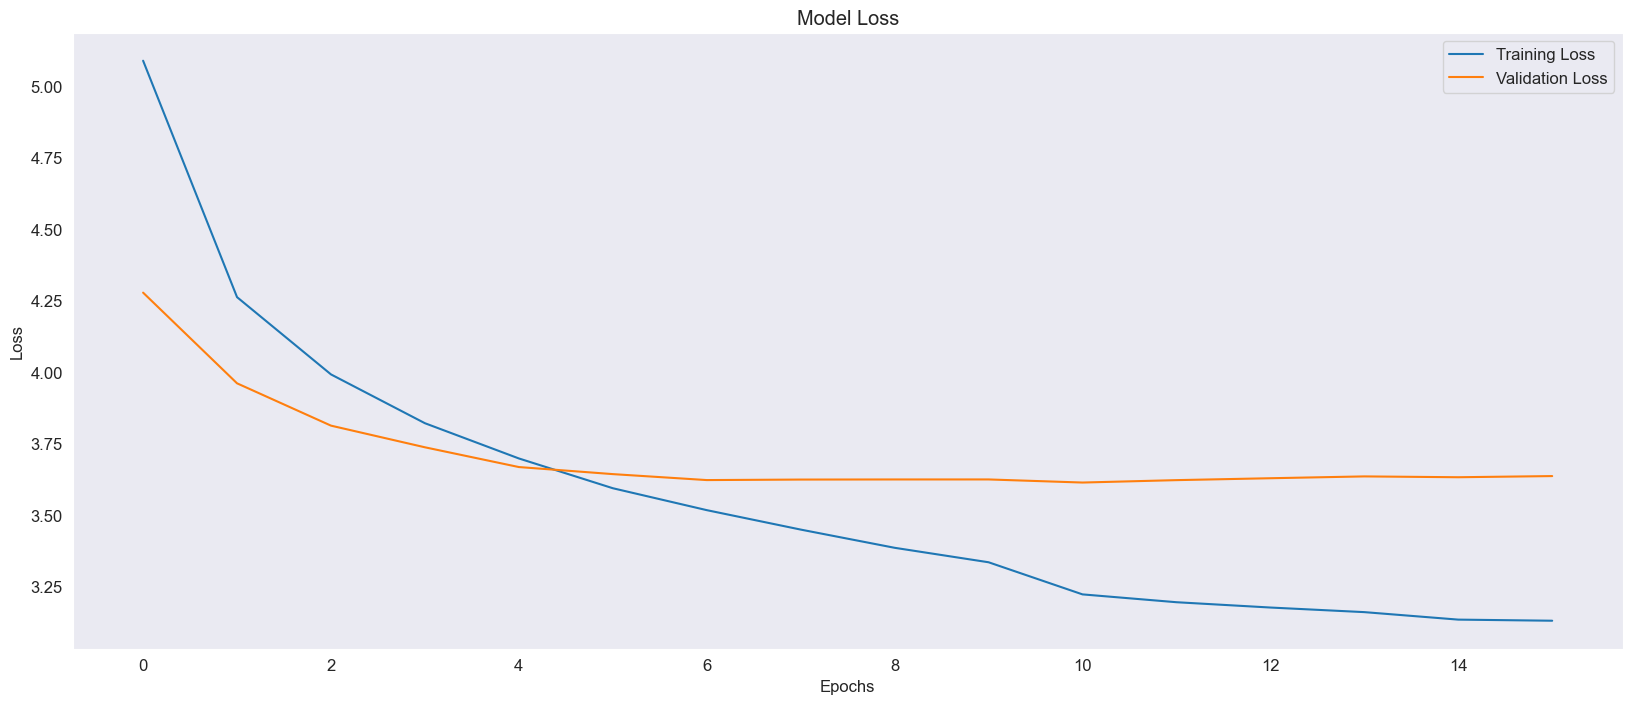

In [34]:
plt.figure(figsize=(20, 8))

# plot with labels
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# titles and labels
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# show legend properly
plt.legend()

# save and show
plt.savefig('model_loss_history.png')
plt.show()


In [27]:
pickle.dump(tokenizer, open("tokenizer.pkl", 'wb'))
pickle.dump(fe, open('feature_extractor.pkl', 'wb'))

In [28]:
#Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
    
# Save feature extractor model
fe.save("feature_extractor.keras")

In [29]:
#load saved file
model_path = 'model.keras'
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path):
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    tokenizer = pickle.load(open("tokenizer.pkl", 'rb'))
    
    # preprocess and read image
    img = load_img(image_path, target_size=(image_size, image_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    
    image_features = feature_extractor.predict(img, verbose=0)
    
    #generate caption for new image
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " "+ word
        if word == 'endseq' :
            break
    caption = in_text.replace('startseq', '').replace("endseq", '').strip()
        
    #display image with caption
    img = load_img(image_path, target_size=(image_size, image_size))
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

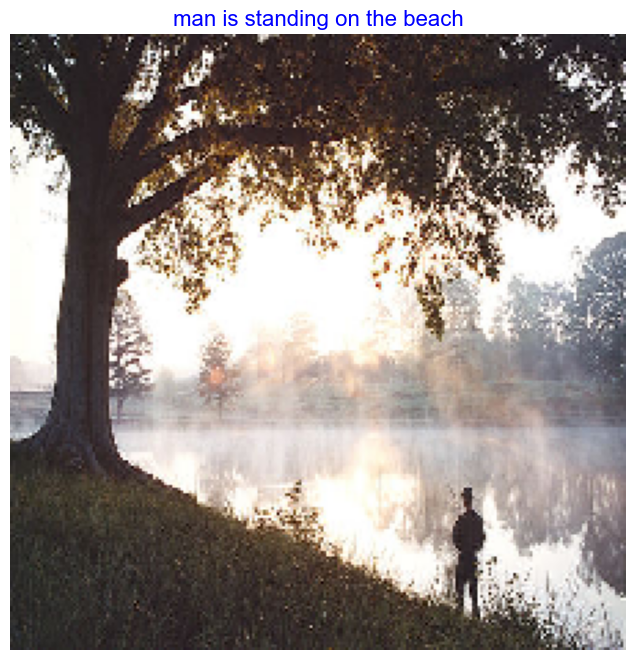

In [ ]:

image_path = "Images/17273391_55cfc7d3d4.jpg" #replace with any
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [32]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
